In [14]:
# Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle as pkl
from matplotlib.ticker import (LogLocator)
from IPython.display import HTML
import os
mpl.rcParams.update({'font.size': 14})

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "data"))
OUTPUTS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "outputs"))

In [15]:
filename = ''

# Load PINN outputs
with open(OUTPUTS_PATH + '/pinn_loss_' + filename + '.pkl', 'rb') as file:
    pinn_loss = pkl.load(file)
    
with open(OUTPUTS_PATH + '/boundary_loss_' + filename + '.pkl', 'rb') as file:
    boundary_loss = pkl.load(file)
    
with open(OUTPUTS_PATH + '/predictions_' + filename + '.pkl', 'rb') as file:
    predictions = pkl.load(file)
    
with open(DATA_PATH + '/f_boundary.pkl', 'rb') as file:
    f_boundary = pkl.load(file)
    
with open(DATA_PATH + '/p.pkl', 'rb') as file:
    p = pkl.load(file)
    
with open(DATA_PATH + '/T.pkl', 'rb') as file:
    T = pkl.load(file)
    
with open(DATA_PATH + '/r_119au.pkl', 'rb') as file:
    r = pkl.load(file)
    
with open(DATA_PATH + '/J.pkl', 'rb') as file:
    J = pkl.load(file)

In [16]:
# Scale prediction and f_boundary back to real space
f_bound = np.array([-34.54346331847909, 6.466899920699378], dtype='float32')
f_boundary = np.exp((f_boundary*np.abs(f_bound[1]-f_bound[0])) + f_bound[0])
predictions = np.exp((predictions*np.abs(f_bound[1]-f_bound[0])) + f_bound[0])

# Get properties
size = int(np.sqrt(predictions.shape[0]))
epochs = int(predictions.shape[2])

# Check data
print(f'F_boundary shape: {f_boundary.shape}, min: {np.min(f_boundary)}, max: {np.max(f_boundary)}')
print(f'Predictions shape: {predictions.shape}, min: {np.min(predictions[:, :, -1].reshape((size, size))[-1, :-1])}, max: {np.max(predictions[:, :, -1].reshape((size, size))[-1, :-1])}')
print("Mean absolute difference in final epoch: ", np.mean(np.abs(predictions[:, :, -1].reshape((size, size))[-1, :] - f_boundary[:, 0])))
# print("Final epoch prediction values for 120 AU and final 10 p values:", predictions[:, :, -1].reshape((size, size))[-1, -10:])

F_boundary shape: (512, 1), min: 9.953227070295088e-16, max: 643.4857432802897
Predictions shape: (262144, 1, 100), min: 1.1097655754739176e-15, max: 261.262797773518
Mean absolute difference in final epoch:  13.400470510745688


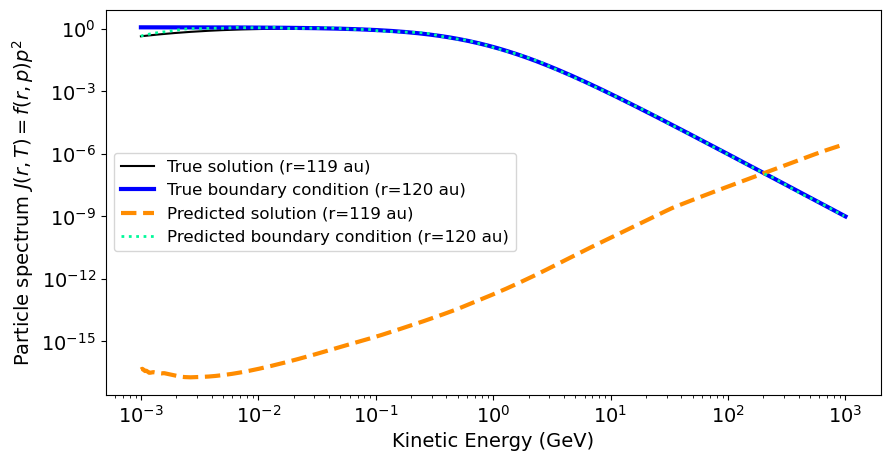

In [17]:
# Plot J(r, T)
fig, ax = plt.subplots(figsize=(10, 5))

ax.loglog(T, J[0, :], label=f'True solution (r={r[0, 0]/150e6:.0f} au)', c='k')
ax.loglog(T, J[-1, :], label=f'True boundary condition (r={r[-1, 0]/150e6:.0f} au)', c='blue', lw='3')
ax.loglog(T[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[0, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[0, 0]/150e6:.0f} au)', c='darkorange', lw='3', ls='--')
ax.loglog(T[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[-1, :-1], axis=1)*(p[:-1]**2), label=f'Predicted boundary condition (r={r[-1, 0]/150e6:.0f} au)', c='mediumspringgreen', lw='2', ls=':')

ax.set_xlabel("Kinetic Energy (GeV)")
ax.set_ylabel("Particle spectrum $J(r, T) = f(r, p) p^2$")
# ax.set_xlim(1e-3, 1e3)
# ax.set_ylim(1e-9, 2e0)
ax.legend(prop={'size': 12})

plt.savefig('prediction.png')

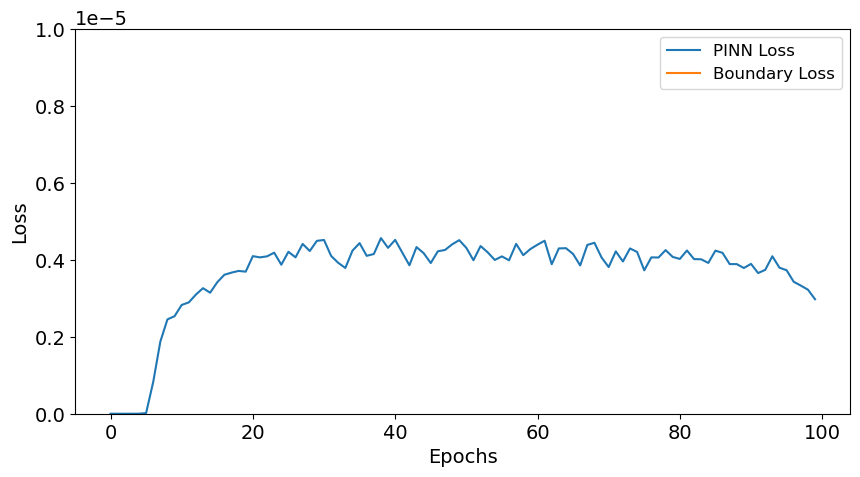

In [21]:
# Plot loss 
fig = plt.figure(figsize=(10, 5))

plt.plot(pinn_loss, label='PINN Loss')
plt.plot(boundary_loss, label='Boundary Loss')

plt.ylim(0, 1e-5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(prop={'size': 12})
plt.savefig("loss.png")

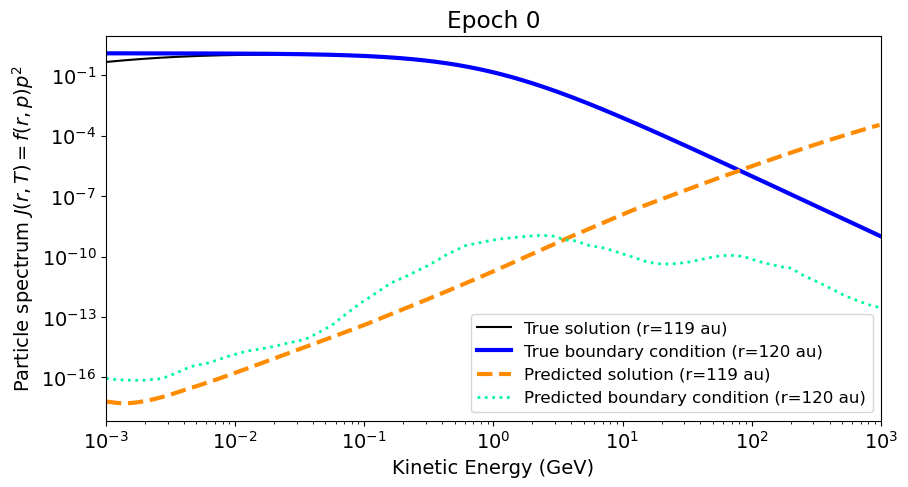

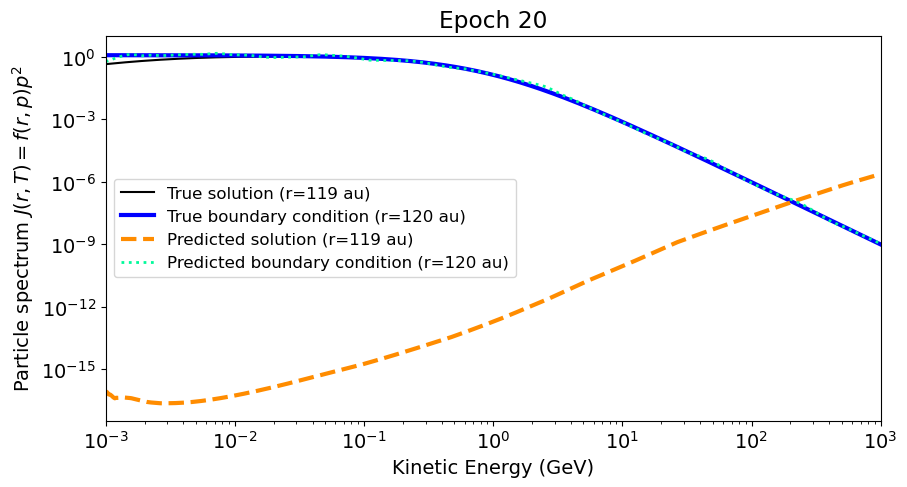

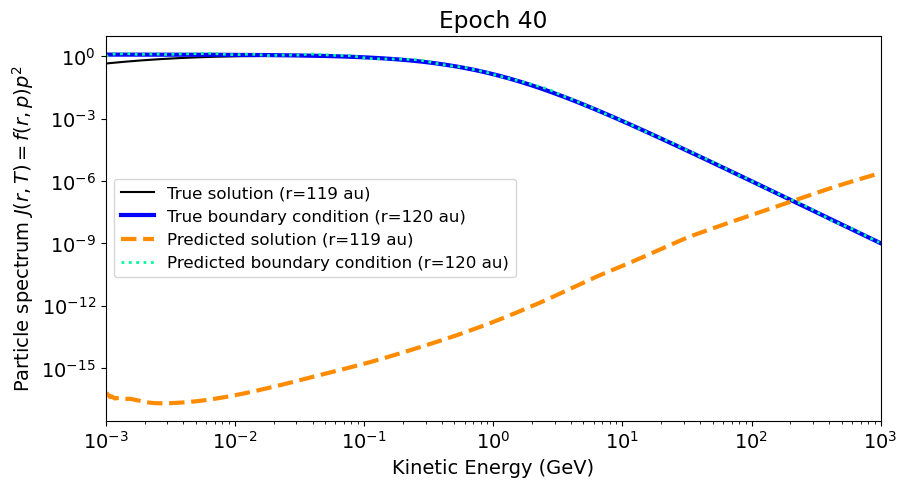

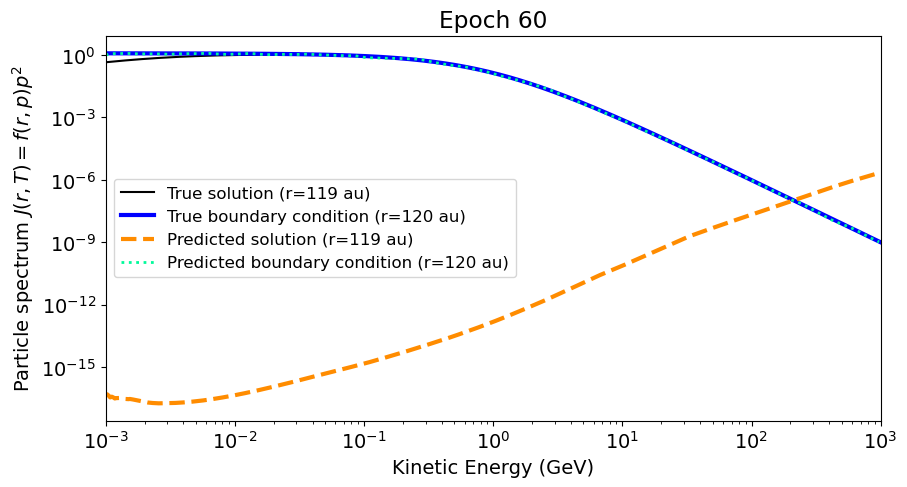

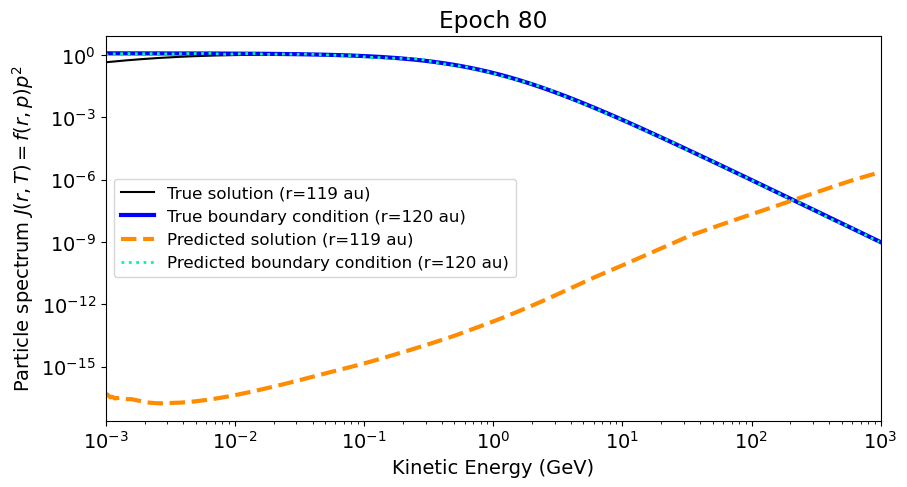

In [19]:
# Visualize J(r, T) over the epochs
for i in range(epochs):
    if (i%20 == 0):
        fig, ax = plt.subplots(figsize=(10, 5))
        
        ax.set_title("Epoch " + str(i))
        ax.set_xlabel("Kinetic Energy (GeV)")
        ax.set_ylabel("Particle spectrum $J(r, T) = f(r, p) p^2$")
        ax.set_xlim(1e-3, 1e3)
        # ax.set_ylim(1e-9, 2e0)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
    
        ax.loglog(T, J[0, :], label=f'True solution (r={r[0, 0]/150e6:.0f} au)', c='k')
        ax.loglog(T, J[-1, :], label=f'True boundary condition (r={r[-1, 0]/150e6:.0f} au)', c='blue', lw='3')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[0, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[0, 0]/150e6:.0f} au)', c='darkorange', lw='3', ls='--')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[-1, :-1], axis=1)*(p[:-1]**2), label=f'Predicted boundary condition (r={r[-1, 0]/150e6:.0f} au)', c='mediumspringgreen', lw='2', ls=':')

        ax.legend(prop={'size': 12})